# Fundamental of Simulation Methods
**Name**: Maximilian Richter

**Matrikel Number**: 3463789

**Student ID**: hy455

## Problem Set 6: FFT-based convolution
### 1. Numeric form of Diffusion Equation
$$-D\frac{T_{i+1} - 2T_i + T_{i-1}}{h^2}=\epsilon_i$$
### 2. Matrix form of the Diffusion Equation
With Dirichlet boundary conditions the 1D diffusion equation becomes $\mathbf{Ax}=\mathbf{b}$, with
$$\mathbf{A}=\left(\begin{array}{rrrrrr}
1 & 0 & & & & \\
1 & -2 & 1 & & & \\
& 1 & -2 & 1 & & \\
& & \cdots & & & \\
& & & 1 & -2 & 1 \\
& & & & 0 & 1
\end{array}\right)$$
and $$\boldsymbol{b}=\left(\begin{array}{c}
y_L \\
-\left(h^2 / D\right) s_2 \\
-\left(h^2 / D\right) s_3 \\
\vdots \\
-\left(h^2 / D\right) s_{N-1} \\
y_R
\end{array}\right)$$
where $\mathbf{x}$ is the desired solution to the Poisson equation.

### 3. Store Matrix Elements into three 1D arrays

In [3]:
import numpy as np
import matplotlib.pyplot as plt

class SimpleCSRMatrix:
    def __init__(self, matrix):
        self.data, self.indices,self.indptr = self.create_csr_matrix(matrix)
        self.shape = matrix.shape

    @staticmethod
    def create_csr_matrix(matrix):
        """
        Convert a dense matrix to a sparse matrix in CSR format.

        Parameters:
        - matrix: Dense matrix (2D numpy array).

        Returns:
        - data: 1D array containing the non-zero values of the matrix.
        - indices: 1D array containing the column indices of the non-zero values.
        - indptr: 1D array indicating the start and end indices of rows in the data and indices arrays.
        """
        # Find non-zero elements and their indices in the matrix
        data = matrix[matrix != 0]
        indices = np.where(matrix != 0)[1]

        # Create indptr array
        indptr = np.zeros(matrix.shape[0] + 1, dtype=int)
        indptr[1:] = np.cumsum(np.sum(matrix != 0, axis=1))

        return data, indices, indptr

    def toarray(self):
        """Create dense representation of sparse matrix

        Returns:
            np.array: Dense matrix
        """
        dense_matrix = np.zeros(self.shape)
        for i in range(self.shape[0]):
            dense_matrix[i, self.indices[self.indptr[i]:self.indptr[i+1]]] = self.data[self.indptr[i]:self.indptr[i+1]]
        return dense_matrix

    # Exercise 4
    def dot(self, vector):
        """Perform matrix vector multiplication

        Args:
            vector (np.array): vector to be multiplied from the right side

        Returns:
            np.array: solution vector 
        """
        result = np.zeros(self.shape[0])
        for i in range(self.shape[0]):
            result[i] = np.dot(self.data[self.indptr[i]:self.indptr[i+1]], vector[self.indices[self.indptr[i]:self.indptr[i+1]]])
        return result

In [4]:
def get_laplacian(N):
    """Get Dense representation of the discrete laplacian operator 

    Args:
        N (int): Number of grid points

    Returns:
        np.array: Dense Laplace Operator
    """
    mat = np.ones(N)

    # Create Laplacian by using diagonal and off diagonal entries
    mat_dense = np.diag(-2*mat) + np.diag(mat[1:], -1) + np.diag(mat[1:], 1)

    # Dirichlet Boundary Conditions
    mat_dense[0,0] = 1
    mat_dense[-1,-1] = 1
    mat_dense[0,1] = 0
    mat_dense[-1,-2] = 0
    return mat_dense

N = 8
laplace_dense = get_laplacian(N)

laplace_sparse = SimpleCSRMatrix(laplace_dense)
print("Sparse Matrix:\n", laplace_sparse.toarray())

b_test = np.arange(8)

print("Multiplication working: ", np.allclose(laplace_sparse.dot(b_test), laplace_dense@b_test))

Sparse Matrix:
 [[ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.  0.  0.  0.]
 [ 0.  1. -2.  1.  0.  0.  0.  0.]
 [ 0.  0.  1. -2.  1.  0.  0.  0.]
 [ 0.  0.  0.  1. -2.  1.  0.  0.]
 [ 0.  0.  0.  0.  1. -2.  1.  0.]
 [ 0.  0.  0.  0.  0.  1. -2.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]]
Multiplication working:  True


### 5. Solve Matrix Equation with Forward/Backward Substitution

In [5]:
def lu_factorization(A):
    """
    Perform LU factorization of a sparse matrix A in CSR format.
    Returns the factors L and U.

    Parameters:
    - A: Sparse matrix in CSR format (numpy.ndarray).

    Returns:
    - L: Lower triangular matrix.
    - U: Upper triangular matrix.
    """
    n = A.shape[0]
    L = np.eye(n)
    U = A.copy()

    for k in range(n - 1):
        for i in range(k + 1, n):
            factor = U[i, k] / U[k, k]
            L[i, k] = factor
            U[i, k:] -= factor * U[k, k:]

    return L, U

def forward_substitution(L, b):
    """
    Perform forward substitution to solve the system Ly = b.

    Parameters:
    - L: Lower triangular matrix.
    - b: Right-hand side vector.

    Returns:
    - y: Solution vector.
    """
    n = L.shape[0]
    y = np.zeros(n)

    for i in range(n):
        y[i] = b[i] - np.dot(L[i, :i], y[:i])

    return y

def backward_substitution(U, y):
    """
    Perform backward substitution to solve the system Ux = y.

    Parameters:
    - U: Upper triangular matrix.
    - y: Right-hand side vector.

    Returns:
    - x: Solution vector.
    """
    n = U.shape[0]
    x = np.zeros(n)

    for i in range(n - 1, -1, -1):
        x[i] = (y[i] - np.dot(U[i, i + 1:].todense()[0], x[i + 1:])) / U[i, i]

    return x

def solve_sparse_system(A, b):
    """
    Solve the sparse linear system Ax = b using LU factorization and
    forward/backward substitution.

    Parameters:
    - A: Sparse matrix in CSR format (numpy.ndarray).
    - b: Right-hand side vector.

    Returns:
    - x: Solution vector.
    """
    L, U = lu_factorization(A)
    y = forward_substitution(L, b)
    x = backward_substitution(U, y)

    return x

For this i used scipys sparse matrix class because i was not able to implement any kind of nice indexing with slices

In [6]:
from scipy.sparse import csr_matrix

laplace_csr = csr_matrix(laplace_dense)

sol =solve_sparse_system(laplace_csr, b_test)

print("Solving Sparse System working: ", np.allclose(b_test, laplace_csr@sol))

Solving Sparse System working:  True


### 6. Apply solver to Diffusion equation

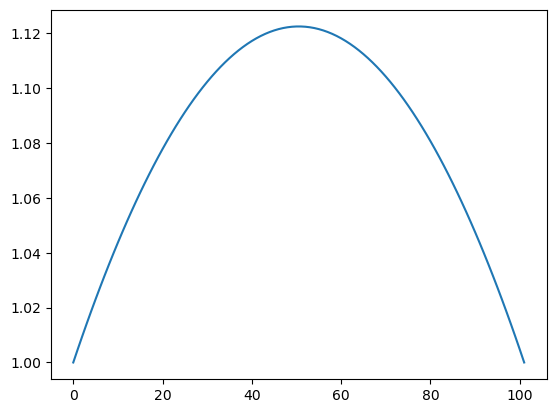

In [7]:
D  = 1   # Diffusion Rate
T0 = 1   # Initial Temperature at boundaries
L  = 1   # Length of domain
N  = 100 + 2 # Grid points
h  = L/N # Cell width

epsilon = np.ones(N)
epsilon[1:-1] = -(h**2/D)*epsilon[1:-1]

laplace_csr = csr_matrix(get_laplacian(N))

T_sol = solve_sparse_system(laplace_csr, epsilon)

plt.plot(T_sol)

### 7. Verification

In [8]:
print(f"Residual is small: {np.sum((laplace_csr@T_sol)-epsilon):.2e}", )


Residual is small: 1.21e-15


### 8. Why is it not exactly Zero?

The residual is not exactly zero because the large amount of floating point operations. In most cases it is not possible to invert a matrix perfectly due to accumulating precision errors.

### 9. Repeat with higher Resolution

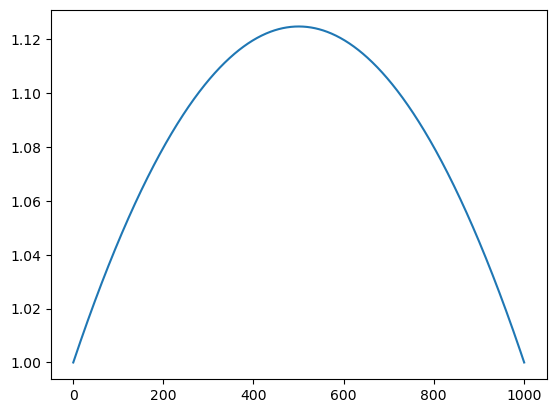

In [88]:
N  = 1000 + 2 # Grid points
h  = L/N # Cell width

epsilon = np.ones(N)
epsilon[1:-1] = -(h**2/D)*epsilon[1:-1]

laplace_csr = csr_matrix(get_laplacian(N))

T_sol = solve_sparse_system(laplace_csr, epsilon)

plt.plot(T_sol)

### 10. Jacobi Iteration Step


In [36]:
def jacobi(A,b,N=25,x=None):
    """Solves the equation Ax=b via the Jacobi iterative method."""
    # Create initial guess if needed
    if x is None:
        x = np.zeros(A[0].shape)

    # Create vector of the diagonal elements and substract them from A
    D = np.diag(A)
    R = A - np.diagflat(D)

    # Iterate for N times
    for i in range(N):
        x = (b - np.dot(R,x)) / D
        
        val = 255-int(i/N*255)
        plt.plot(x, color="#{:02x}{:02x}{:02x}".format(val, val ,val)) 
    return x


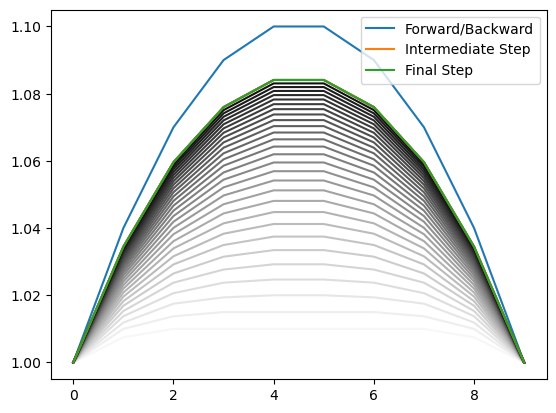

In [38]:
N  = 8 + 2 # Grid points

h  = L/N # Cell width

epsilon = np.ones(N)
epsilon[1:-1] = -(h**2/D)*epsilon[1:-1]

laplace_dense = get_laplacian(N)
laplace_csr = csr_matrix(laplace_dense)

T_sol = solve_sparse_system(laplace_csr, epsilon)

plt.figure()
plt.plot(T_sol, label="Forward/Backward")


sol = jacobi(laplace_dense, epsilon, N=30, x=np.ones(epsilon.shape))

plt.plot(sol, label="Intermediate Steps", color="black")
plt.plot(sol, label="Final Step")
plt.legend()

### 11. Repeat with higher Resolution

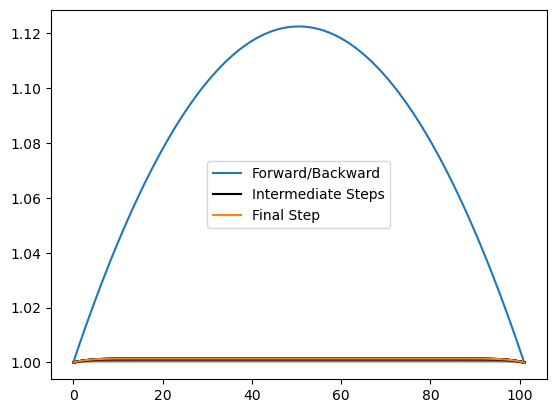

In [41]:
N  = 100 + 2 # Grid points

h  = L/N # Cell width

epsilon = np.ones(N)
epsilon[1:-1] = -(h**2/D)*epsilon[1:-1]

laplace_dense = get_laplacian(N)
laplace_csr = csr_matrix(laplace_dense)

T_sol = solve_sparse_system(laplace_csr, epsilon)

plt.figure()
plt.plot(T_sol, label="Forward/Backward")

sol = jacobi(laplace_dense, epsilon, N=30, x=np.ones(epsilon.shape))

plt.plot(sol, label="Intermediate Steps", color="black")
plt.plot(sol, label="Final Step")
plt.legend()

The case with the small grid size converges significantly faster than the case with the high grid size. This is because it takes much longer for information to propagate from one end to another. The change in the solution vector per step also scales with the size of the matrix. 